# Classical Search: Sequential guess and check

Let's say there is a secret key and we want to write an algorithm that will guess it as efficiently as possible. We don't know how the key was chosen, and there is no way to inspect the function.

For one example, let's say the key is an integer between 0 and n. We are provided a function that will take our guess as an input and return true or false if the guess matches, but we do not know anything else. Even though this example is an ordered list, we don't know if our guess was lower or higher than the key so we can't binary search.

The best we can do is check each item sequentially until we find the target. Since the key could be any int in the range with equal probability, on average we'll need to check n/2 items before finding it. This is because sometimes we'll get lucky and find it early, and other times we'll need to search almost the entire database.

Our simulation below running this 10k times confirms this -- with n=1000, we get an average of around 500 steps per search, which is n/2 as expected and runs in O(n) time.


In [16]:
import random
import statistics

def new_game(field_size):
    key_value = random.randint(0, field_size-1)
    return lambda x: x == key_value

def classical_search(field_size):
    game = new_game(field_size)
    found = False
    guess = 0
    while not found:
        found = game(guess)
        guess += 1
    return guess # number of guesses made, not key found

def get_classical_average():
    games = 10000
    field_size = 1000
    results = [classical_search(field_size) for _ in range(games)]
    steps = statistics.mean(results)

    print(f"Games: {games}, Range: {field_size}")
    print(f"Avg steps per game: {steps:.0f}")

get_classical_average()


Games: 10000, Range: 1000
Avg steps per game: 502


# Quantum search: Grover's algorithm

While O(n) is the best case for a classical algorithm, we can find a quantum optimization. It will be much more efficient and is a good example of where quantum computing can have advantages, but it won't be exponentially better. We can easily throw more compute power at the classical algorithm to outperform the more efficient quantum algorithm that is still hardware constrained.

Grover's algorithm is a quantum algorithm to solve the same problem as above, but it will do it in O(√n) time, gaining us a quadratic improvement.

Classical: Needs an average of n/2 steps, 1000 range = 500 steps  
Quantum: Needs an average of √n steps, 1000 range = ~32 steps

Remember, a common misconception is that quantum algorithms can run classical computations in parralell to each other. This approach won't be quicker because it can run the same 500 steps all at the same time; it will be quicker because it is able to operate in a completely different state. We will create a superposition of all of the inputs together, and get a superposition of all of the outputs together. That is not the same as running each indiviudal input on their own all at the same time.


## Game setup
Let's say we are searching for a key in the range 0–9 (n=10). In classical computing, this was intuitive:
* A random key is chosen within the range; for example, let's choose 6.
* A function checks whether our guess matches the key.
* We guess sequentially: 0, 1, 2, 3, 4, 5, and finally 6, stopping once the function returns true.

In quantum computing, the setup is more intricate:
* We represent the range 0–9 in binary as $0000$ – $1001$.
* We select the same key (6), represented as $0110$ in binary.
* The function that checks our guess is now called the oracle. It "marks" one specific computational basis state ($0110$) by assigning it a phase of -1, leaving all other states with a phase of +1. Our marked state is now $-\ket{0110}$

In [88]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

Target key: 0100


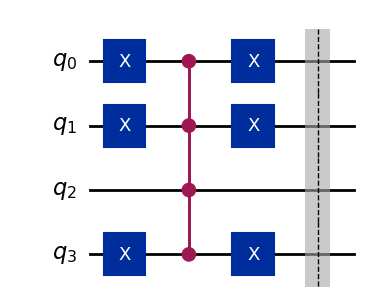

In [99]:
def grover_oracle(marked_state):
    num_qubits = len(marked_state)
    qc = QuantumCircuit(num_qubits)
    # flip order to match Qiskit bit ordering
    # q0 = LSB
    rev_target = marked_state[::-1]
    # find index of all 0 bits
    zero_indexs = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
    # flip all 0s to 1s with NOT gates
    if (len(zero_indexs)):
        qc.x(zero_indexs)
    # apply a negative phase to the state of all 1s
    qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
    # flip those previous bits back to 0s
    if (len(zero_indexs)):
        qc.x(zero_indexs)
    return qc

bits = 4
field_size = int(math.exp2(4))
key_int = random.randint(0, field_size-1)
key = format(key_int, f'0{bits}b')
# key = "0110"
print(f"Target key: {key}")
oracle = grover_oracle(key)
oracle.barrier()
oracle.draw(output="mpl", style="iqp")

Grover's algorithm repeatedly applies the following combination of gates, known as the Grover iterate or Grover operator:

$G = H^{\otimes n} Z_{\text{OR}} H^{\otimes n} Z_f$

In Qiskit, this sequence is conveniently predefined as a single operator, simplifying its implementation. We'll use the below circuit multiple times.

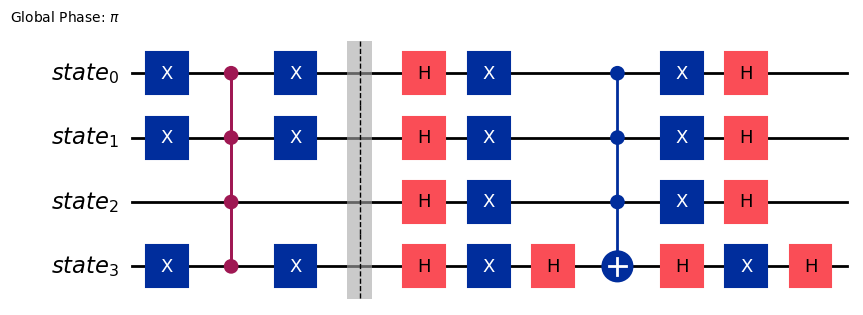

In [100]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

## Executing Grover's
* We need to create an even superposition of all computational basis states by using a H gate on each qubit.
* Follow that with the Grover operator repeated enough times to increase the probability of finding our target. We'll use the square root of the field size

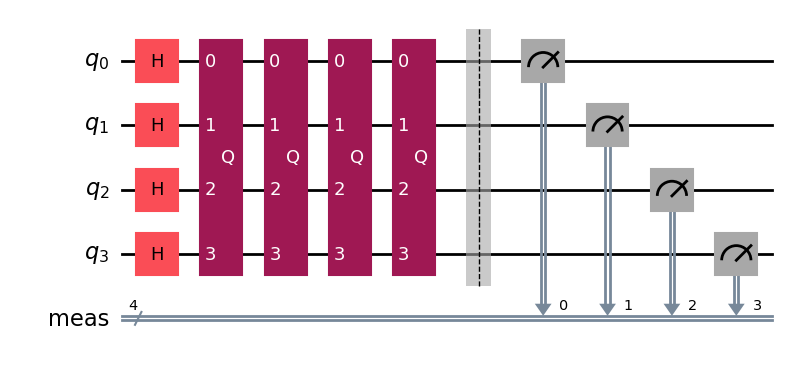

In [101]:
iterations = int(math.floor(math.sqrt(field_size)))

qc = QuantumCircuit(grover_op.num_qubits)
# Even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover optimal number of times
qc.compose(grover_op.power(iterations), inplace=True)
# Measure for result
qc.measure_all()
qc.draw(output="mpl", style="iqp")

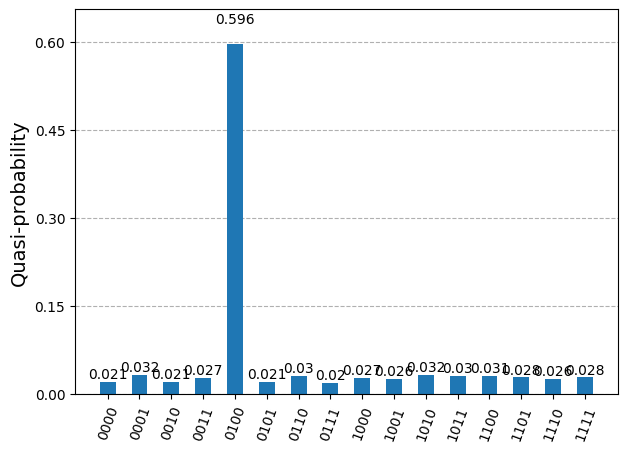

In [102]:
def run_on_hardware():
    # Use this to run on IBM quantum hardware
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.least_busy(operational=True, simulator=False)
    backend.name

    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")
    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 10_000
    result = sampler.run([circuit_isa]).result()
    return result[0].data.meas.get_counts()

def run_local_simulator():
    sampler = StatevectorSampler()
    result = sampler.run([qc]).result()
    return result[0].data.meas.get_counts()

dist = run_local_simulator()
plot_distribution(dist)